In [71]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt


In [32]:
import os

import numpy as np
import loader as L


from scipy.interpolate import griddata, interp1d

# from __future__ import print_function # (not needed in python3)

from scipy.ndimage import rotate

from functools import partial
from math import sin, cos, pi

In [80]:
import logging
import sys
from braindecode.datasets.bbci import  BBCIDataset
from collections import OrderedDict
from braindecode.datautil.trial_segment import \
    create_signal_target_from_raw_mne
from braindecode.mne_ext.signalproc import mne_apply, resample_cnt
from braindecode.datautil.signalproc import highpass_cnt
from braindecode.datautil.signalproc import exponential_running_standardize


log = logging.getLogger(__name__)
log.setLevel('DEBUG')

logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                 level=logging.DEBUG, stream=sys.stdout)

In [33]:

locs = [[ 35.5,  -0.1 ],    # Fz
        [ 12.2,  56.16],    # FC3
        [  9.9,  27.6 ],    # FC1
        [  9.4,  -0.1 ],    # FCz
        [ 10.5, -28.32],    # FC2
        [ 13  , -57   ],    # FC4
        [-15.1,  87.48],    # C5
        [-16.2,  57.48],    # C3
        [-16.5,  28.44],    # C1
        [-16.8, - 0.1 ],    # Cz
        [-16.3, -29.64],    # C2
        [-15.5, -58.68],    # C4
        [-14.1, -87.6 ],    # C6
        [-40.9,  53.16],    # CP3
        [-39.3,  26.4 ],    # CP1
        [-39.3, - 0.12],    # CPz
        [-38.9, -27.84],    # CP2
        [-40.2, -54.24],    # CP4
        [-65.5,  22.08],    # P1
        [-63.8, - 0.12],    # Pz
        [-65.1, -23.28],    # P2
        [-79.7, - 0.1 ]]    # POz

locs = np.array(locs)

channel_labels = ['Fz'
        , 'FC3'
        , 'FC1'
        , 'FCz'
        , 'FC2'
        , 'FC4'
        , 'C5'
        , 'C3'
        , 'C1'
        , 'Cz'
        , 'C2'
        , 'C4'
        , 'C6'
        , 'CP3'
        , 'CP1'
        , 'CPz'
        , 'CP2'
        , 'CP4'
        , 'P1'
        , 'Pz'
        , 'P2'
        , 'POz'
        ]


gridsize = 32



features = L.train_set.X
labels = L.train_set.y


In [34]:
# channel_labels[0]  # highest
# channel_labels[6]  # leftmost
# channel_labels[12] # rightmost
# channel_labels[21] # lowest

In [35]:
# this now is a function, to find out min/max values of lists.

In [36]:
def minmax(l: list) -> tuple:
    assert len(l) > 0
    minval = l[0]
    maxval = l[0]
    for v in l:
        if v > maxval:
            maxval = v
        if v < minval:
            minval = v
    return (minval, maxval)

In [37]:
def fst(l: list) -> list:
    return list(map(lambda v: v[0], l))

def snd(l: list) -> list:
    return list(map(lambda v: v[1], l))

In [38]:
minmax(fst(locs)), minmax(snd(locs))

((-79.7, 35.5), (-87.6, 87.48))

In [39]:
(87.5 * 2) / (79.7 + 35.5)

1.519097222222222

In [40]:
(-79.7 + 35.5) / 2

-22.1

In [41]:
locsn = list(zip(map(lambda x: (x + 21.1) * 1.519, fst(locs)), snd(locs)))

In [42]:
locsn

[(85.9754, -0.1),
 (50.582699999999996, 56.16),
 (47.089, 27.6),
 (46.329499999999996, -0.1),
 (48.0004, -28.32),
 (51.7979, -57.0),
 (9.114000000000003, 87.48),
 (7.443100000000003, 57.48),
 (6.987400000000002, 28.44),
 (6.531700000000001, -0.1),
 (7.291200000000001, -29.64),
 (8.506400000000001, -58.68),
 (10.633000000000003, -87.6),
 (-30.076199999999993, 53.16),
 (-27.64579999999999, 26.4),
 (-27.64579999999999, -0.12),
 (-27.038199999999993, -27.84),
 (-29.012900000000002, -54.24),
 (-67.44359999999999, 22.08),
 (-64.86129999999999, -0.12),
 (-66.83599999999998, -23.28),
 (-89.01339999999999, -0.1)]

In [43]:
# testing rotation (and rescaling to square) before actually adding it to the code.

In [44]:
def rotate2D(point: list) -> list:
    degree = (45 * 2 * pi) / 360
    return [point[0] * cos(degree) - point[1] * sin(degree), point[0] * sin(degree) + point[1] * cos(degree)]

In [45]:
locsr = np.array(list(map(rotate2D, locsn)))

In [46]:
locsr

array([[ 60.86449903,  60.72307768],
       [ -3.94374665,  75.47848701],
       [ 13.78080406,  52.81309838],
       [ 32.8306143 ,  32.68919294],
       [ 53.96667238,  13.9161443 ],
       [ 76.93173287,  -3.67844019],
       [-55.41313001,  68.30227242],
       [-35.3814313 ,  45.90756427],
       [-15.16927893,  25.05095478],
       [  4.68932004,   4.54789868],
       [ 26.11430196, -15.80298803],
       [ 47.50795904, -35.4780928 ],
       [ 69.46122044, -54.42388763],
       [-58.85688146,  16.32271152],
       [-38.21615167,  -0.88091363],
       [-19.46367984, -19.63338547],
       [  0.56695822, -38.80474736],
       [ 17.83825348, -58.86869014],
       [-63.30274464, -32.07690918],
       [-45.77901225, -45.94871788],
       [-30.79874296, -63.72163469],
       [-62.87126808, -63.01268943]])

In [47]:
locs

array([[ 35.5 ,  -0.1 ],
       [ 12.2 ,  56.16],
       [  9.9 ,  27.6 ],
       [  9.4 ,  -0.1 ],
       [ 10.5 , -28.32],
       [ 13.  , -57.  ],
       [-15.1 ,  87.48],
       [-16.2 ,  57.48],
       [-16.5 ,  28.44],
       [-16.8 ,  -0.1 ],
       [-16.3 , -29.64],
       [-15.5 , -58.68],
       [-14.1 , -87.6 ],
       [-40.9 ,  53.16],
       [-39.3 ,  26.4 ],
       [-39.3 ,  -0.12],
       [-38.9 , -27.84],
       [-40.2 , -54.24],
       [-65.5 ,  22.08],
       [-63.8 ,  -0.12],
       [-65.1 , -23.28],
       [-79.7 ,  -0.1 ]])

In [48]:
# def gen_images(locs, features, n_gridpoints, normalize=True,
#                augment=False, pca=False, std_mult=0.1, n_components=2, edgeless=False):
# needs defined: locs, features, n_gridpoints

def interpolate(locs, features, n_gridpoints=32, rotate=True, edge_channels=[0, 6, 12, 21]):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode

    :param locs: An array with shape [n_electrodes, 2] containing X, Y coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                        Features are as columns.
                        Features corresponding to each frequency band are concatenated.
                        (alpha1, alpha2, ..., beta1, beta2,...)
    :param n_gridpoints: Number of pixels in the output images
    :rotate: If the whole image should be rotated by 45 degrees and fit to a square.
    :edge_channels: The indices of the channels with the
                    highest, leftmost, rightmost and lowest coordinates.
                    Only relevant when rotating.
                    (Assuming that Fz is on the x axis to the right.)
    
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """
    
    if rotate:
        high_x = locs[edge_channels[0]][0]
        high_y = locs[edge_channels[1]][1]
        low_y  = locs[edge_channels[2]][1]
        low_x  = locs[edge_channels[3]][0]
        
        t_x = abs(high_x) + abs(low_x)
        t_y = abs(high_y) + abs(low_y)
        
        factor = t_y / t_x
        
        # centering:
        xdiff = (high_x + low_x) / 2
        ydiff = (high_y + low_y) / 2
        
        locst = zip(map(lambda x: (x - xdiff) * factor, fst(locs)),
                    map(lambda y: (y - ydiff), snd(locs)))
        
        locs = np.array(list(map(rotate2D, locst)))
    
    cut = lambda a: a if len(a.shape) < 3 else a[:, :, 0]
    
    feat_array_temp = []
    nElectrodes = locs.shape[0]     # Number of electrodes
    # Test whether the feature vector length is divisible by number of electrodes
    assert features.shape[1] % nElectrodes == 0
    n_colors = int(features.shape[1] / nElectrodes)
    for c in range(n_colors):
        feat_array_temp.append(cut(features[:, c * nElectrodes : nElectrodes * (c+1)]))
    nSamples = features.shape[0]
    # getting some surrounding values right
    grid_x, grid_y = np.mgrid[
                     min(locs[:, 0]):max(locs[:, 0]):n_gridpoints*1j,
                     min(locs[:, 1]):max(locs[:, 1]):n_gridpoints*1j
                     ]
    temp_interp = []
    for c in range(n_colors):
        temp_interp.append(np.zeros([nSamples, n_gridpoints, n_gridpoints]))
    # Interpolating
    for i in range(nSamples):
        for c in range(n_colors):
            temp_interp[c][i, :, :] = cut(griddata(locs, feat_array_temp[c][i, :], (grid_x, grid_y),
                                    method='cubic', fill_value=np.nan))
    #                                 method='cubic', fill_value=np.nan)# [:, :, 0]
    #                                 method='cubic', fill_value=np.nan)
        print('Interpolating {0}/{1}'.format(i+1, nSamples), end='\r')
    images = np.swapaxes(np.asarray(temp_interp), 0, 1)     # swap axes to have [samples, colors, W, H]
    return images

In [49]:
images = interpolate(locsr, features, gridsize)

In [50]:
a, b = minmax(fst(locs))
a, b

(-79.7, 35.5)

In [51]:
a + b

-44.2

In [52]:
a - (a + b) / 2

-57.6

In [53]:
b - (a + b) / 2

57.6

In [54]:
# mx = interp1d(minmax(fst(locs)), [0, gridsize])
# my = interp1d(minmax(snd(locs)), [0, gridsize])

In [55]:
mx = interp1d

In [56]:
images2 = images[:]

In [57]:
for i in range(images.shape[0]):
    print('Saving {0}/{1}'.format(i+1, images.shape[0]), end='\r')
    # for i in range(22):
    #     plt.text(my(locsr[i][1]), mx(locsr[i][0]), channel_labels[i])
    plt.imshow(images[i,0,:,:], cmap='RdYlBu') # , interpolation='bilinear')
    plt.savefig(os.path.join('images3/','%d.png' % i))
    plt.close()

In [58]:
a = np.array([])

In [59]:
images.shape

(288, 1, 32, 32)

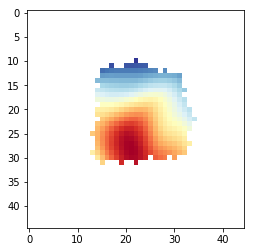

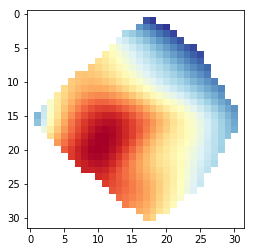

In [60]:
i = 0
plt.imshow(rotate(images[i,0,:,:], 45, cval=np.nan, prefilter=False), cmap='RdYlBu')
plt.savefig(os.path.join('images4/','%d.png' % i))
plt.show()
plt.close()
plt.imshow(images[i,0,:,:], cmap='RdYlBu')
plt.show()
plt.close()
# plt.savefig(os.path.join('images4/','%d.png' % i))
# plt.close()

In [61]:
tight_cap_positions = [
    ['', '', '', '', 'Fp1', 'FPz', 'Fp2', '', '', '', ''],
    ['', '', '', 'AFp3h', '', '', '', 'Afp4h', '', '', ''],
    ['', 'AF7', 'AF5', 'AF3', 'AF1', 'AFz', 'AF2', 'AF4', 'AF6', 'AF8', ''],
    ['', '', 'AFF5h', '', 'AFF1', '', 'AFF2', '', 'AFF6h', '', ''],
    ['', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', ''],
    ['FFT9h', 'FFT7h', 'FFC5h', 'FFC3h', 'FFC1h', '', 'FFC2h', 'FFC4h', 'FFC6h', 'FFT8h', 'FFT10h'],
    ['FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10'],
    ['FTT9h', 'FTT7h', 'FCC5h', 'FCC3h', 'FCC1h', '', 'FCC2h', 'FCC4h', 'FCC6h', 'FTT8h', 'FTT10h'],
    ['M1', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'M2'],
    ['', 'TTP7h', 'CCP5h', 'CCP3h', 'CCP1h', '', 'CCP2h', 'CCP4h', 'CCP6h', 'TTP8h', ''],
    ['TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10'],
    ['TPP9h', 'TPP7h', 'CPP5h', 'CPP3h', 'CPP1h', '', 'CPP2h', 'CPP4h', 'CPP6h', 'TPP8h', 'TPP10h'],
    ['P9', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'P10'],
    ['PPO9h', '', 'PPO5h', '', 'PPO1', '', 'PPO2', '', 'PPO6h', '', 'PPO10h'],
    ['PO9', 'PO7', 'PO5', 'PO3', 'PO1', 'POz', 'PO2', 'PO4', 'PO6', 'PO8', 'PO10'],
    ['POO9h', '', '', 'POO3h', '', '', '', 'POO4h', '', '', 'POO10h'],
    ['', '', '', '', 'O1', 'Oz', 'O2', '', '', '', ''],
    ['', '', '', '', 'OI1h', '', 'OI2h', '', '', '', ''],
    ['', '', '', '', 'I1', 'Iz', 'I2', '', '', '', '']]



In [62]:
def mapper(locs):
    def actual(values):
        nmap = np.empty((19, 11))
        for i, row in enumerate(tight_cap_positions):
            for j, col in enumerate(row):
                if col in locs:
                    ind = locs.index(col)
                    nmap[i, j] = values[ind]
                else:
                    nmap[i, j] = np.nan
        return nmap
    return actual

In [64]:
a = mapper(channel_labels)

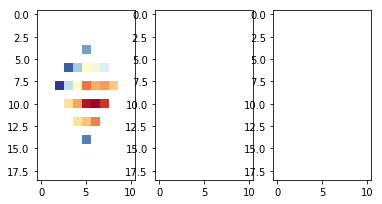

In [65]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(a(features[0, :, 0]), cmap='RdYlBu', interpolation='nearest')
ax[1].imshow(a(features[0, :, 0]), cmap='RdYlBu', interpolation='bilinear')
ax[2].imshow(a(features[0, :, 0]), cmap='RdYlBu', interpolation='bicubic')

In [66]:
# plt.imshow(a(features[0, :, 0]), cmap='RdYlBu', interpolation='nearest')
# plt.imshow(a(features[0, :, 0]), cmap='RdYlBu')
list(zip(a(features[0, :, 0])[~np.isnan(a(features[0, :, 0]))],np.argwhere(~np.isnan(a(features[0, :, 0])))))

[(-0.3471706211566925, array([4, 5])),
 (-0.23249119520187378, array([6, 3])),
 (-0.43726664781570435, array([6, 4])),
 (-0.6453673839569092, array([6, 5])),
 (-0.6139683127403259, array([6, 6])),
 (-0.5441974401473999, array([6, 7])),
 (-0.16961045563220978, array([8, 2])),
 (-0.4903051257133484, array([8, 3])),
 (-0.6457424163818359, array([8, 4])),
 (-0.9326569437980652, array([8, 5])),
 (-0.8416663408279419, array([8, 6])),
 (-0.870374321937561, array([8, 7])),
 (-0.7874346375465393, array([8, 8])),
 (-0.74143385887146, array([10,  3])),
 (-0.8544210195541382, array([10,  4])),
 (-1.0963177680969238, array([10,  5])),
 (-1.1308053731918335, array([10,  6])),
 (-1.0354777574539185, array([10,  7])),
 (-0.7309961915016174, array([12,  4])),
 (-0.8004339933395386, array([12,  5])),
 (-0.9123595356941223, array([12,  6])),
 (-0.28675687313079834, array([14,  5]))]

In [67]:
points = list(map(tuple, np.argwhere(~np.isnan(a(features[0, :, 0])))))
values = a(features[0, :, 0])[~np.isnan(a(features[0, :, 0]))]
image = griddata(points, values, tuple(np.mgrid[0:19, 0:11]), method='linear')

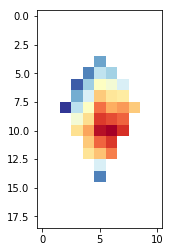

In [68]:
plt.imshow(image, cmap='RdYlBu')

In [97]:

def load_bbci_data(filename, low_cut_hz, debug=False):
    load_sensor_names = None
    if debug:
        load_sensor_names = ['C3', 'C4', 'C2']
    # we loaded all sensors to always get same cleaning results independent of sensor selection
    # There is an inbuilt heuristic that tries to use only EEG channels and that definitely
    # works for datasets in our paper
    loader = BBCIDataset(filename, load_sensor_names=load_sensor_names)

    log.info("Loading data...")
    cnt = loader.load()

    # Cleaning: First find all trials that have absolute microvolt values
    # larger than +- 800 inside them and remember them for removal later
    log.info("Cutting trials...")

    marker_def = OrderedDict([('Right Hand', [1]), ('Left Hand', [2],),
                              ('Rest', [3]), ('Feet', [4])])
    clean_ival = [0, 4000]

    set_for_cleaning = create_signal_target_from_raw_mne(cnt, marker_def,
                                                  clean_ival)

    clean_trial_mask = np.max(np.abs(set_for_cleaning.X), axis=(1, 2)) < 800

    log.info("Clean trials: {:3d}  of {:3d} ({:5.1f}%)".format(
        np.sum(clean_trial_mask),
        len(set_for_cleaning.X),
        np.mean(clean_trial_mask) * 100))

    # now pick only sensors with C in their name
    # as they cover motor cortex
    C_sensors = ['FC5', 'FC1', 'FC2', 'FC6', 'C3', 'C4', 'CP5',
                 'CP1', 'CP2', 'CP6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2',
                 'C6',
                 'CP3', 'CPz', 'CP4', 'FFC5h', 'FFC3h', 'FFC4h', 'FFC6h',
                 'FCC5h',
                 'FCC3h', 'FCC4h', 'FCC6h', 'CCP5h', 'CCP3h', 'CCP4h', 'CCP6h',
                 'CPP5h',
                 'CPP3h', 'CPP4h', 'CPP6h', 'FFC1h', 'FFC2h', 'FCC1h', 'FCC2h',
                 'CCP1h',
                 'CCP2h', 'CPP1h', 'CPP2h']
    if debug:
        C_sensors = load_sensor_names
    # cnt = cnt.pick_channels(C_sensors)

    # Further preprocessings as descibed in paper
    log.info("Resampling...")
    cnt = resample_cnt(cnt, 250.0)
    log.info("Highpassing...")
    cnt = mne_apply(
        lambda a: highpass_cnt(
            a, low_cut_hz, cnt.info['sfreq'], filt_order=3, axis=1),
        cnt)
    log.info("Standardizing...")
    cnt = mne_apply(
        lambda a: exponential_running_standardize(a.T, factor_new=1e-3,
                                                  init_block_size=1000,
                                                  eps=1e-4).T,
        cnt)

    # Trial interval, start at -500 already, since improved decoding for networks
    ival = [-500, 4000]

    dataset = create_signal_target_from_raw_mne(cnt, marker_def, ival)
    dataset.X = dataset.X[clean_trial_mask]
    dataset.y = dataset.y[clean_trial_mask]
    return dataset

In [98]:
# filename = "/datadisk/Coding/high-gamma-dataset/data/train/1.mat"
filename = "/media/ced/HDD/Coding/high-gamma-dataset/data/train/1.mat"
low_cut_hz = 4
data = load_bbci_data(filename=filename, low_cut_hz=low_cut_hz)

2019-04-06 18:41:43,155 INFO : Loading data...
Creating RawArray with float64 data, n_channels=128, n_times=1225545
    Range : 0 ... 1225544 =      0.000 ...  2451.088 secs
Ready.
2019-04-06 18:42:02,259 INFO : Cutting trials...
2019-04-06 18:42:04,702 INFO : Trial per class:
Counter({'Right Hand': 80, 'Rest': 80, 'Feet': 80, 'Left Hand': 80})
2019-04-06 18:42:06,863 INFO : Clean trials: 319  of 320 ( 99.7%)
2019-04-06 18:42:06,864 INFO : Resampling...
2019-04-06 18:42:06,866 WARNING : This is not causal, uses future data....
2019-04-06 18:42:06,867 INFO : Resampling from 500.000000 to 250.000000 Hz.
Creating RawArray with float64 data, n_channels=129, n_times=612772
    Range : 0 ... 612771 =      0.000 ...  2451.084 secs
Ready.
2019-04-06 18:42:30,837 INFO : Highpassing...
2019-04-06 18:42:33,825 INFO : Standardizing...
2019-04-06 18:43:10,376 INFO : Trial per class:
Counter({'Right Hand': 80, 'Rest': 80, 'Feet': 80, 'Left Hand': 80})


In [99]:
d = data.X[0, :, 0]
d = d - d.mean()

In [121]:
positions = [
 'Fp1', 'Fp2', 'Fpz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5',
 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2',
 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz',
 'O1', 'Oz', 'O2', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1',
 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3',
 'CPz', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6',
 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT9', 'FT10', 'TPP9h',
 'TPP10h', 'PO9', 'PO10', 'P9', 'P10', 'AFF1', 'AFz', 'AFF2', 'FFC5h',
 'FFC3h', 'FFC4h', 'FFC6h', 'FCC5h', 'FCC3h', 'FCC4h', 'FCC6h',
 'CCP5h', 'CCP3h', 'CCP4h', 'CCP6h', 'CPP5h', 'CPP3h', 'CPP4h',
 'CPP6h', 'PPO1', 'PPO2', 'I1', 'Iz', 'I2', 'AFp3h', 'AFp4h', 'AFF5h',
 'AFF6h', 'FFT7h', 'FFC1h', 'FFC2h', 'FFT8h', 'FTT9h', 'FTT7h',
 'FCC1h', 'FCC2h', 'FTT8h', 'FTT10h', 'TTP7h', 'CCP1h', 'CCP2h',
 'TTP8h', 'TPP7h', 'CPP1h', 'CPP2h', 'TPP8h', 'PPO9h', 'PPO5h',
 'PPO6h', 'PPO10h', 'POO9h', 'POO3h', 'POO4h', 'POO10h', 'OI1h',
 'OI2h', 'STI 014']


In [104]:
b = mapper(positions)

In [128]:
# values.reshape(1, 126)

In [136]:
points = list(map(tuple, np.argwhere(~np.isnan(b(d)))))
values = b(d)[~np.isnan(b(d))]
image = griddata(points, values, tuple(np.mgrid[0:19, 0:11]), method='linear')
values = values.reshape(1, 126)
image2 = interpolate(np.array(points), values)

2019-04-06 19:17:19,831 DEBUG : update_title_pos
2019-04-06 19:17:19,909 DEBUG : update_title_pos
2019-04-06 19:17:19,989 DEBUG : update_title_pos
2019-04-06 19:17:20,054 DEBUG : update_title_pos
2019-04-06 19:17:20,088 DEBUG : update_title_pos


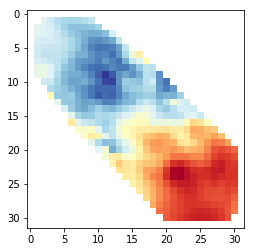

In [137]:
# plt.imshow(b(d), cmap='RdYlBu')
# plt.imshow(image, cmap='RdYlBu')
plt.imshow(image2[0, 0], cmap='RdYlBu')

In [89]:
data.X.shape

(319, 44, 1125)